# X-RAY 의료영상데이터로 폐렴 진단해보기
  
이번 프로젝트는 Kaggle의 Chest X-Ray 이미지 데이터를 가지고 해당 이미지가 폐렴인지 또는 정상인지를 분류하는 모델을 만들어보았다.  
Chest X-Ray 데이터 크기는 1.2GB이고 총 5856개로 많은 편은 아니며 label은 정상과 폐렴 두 범주로 나뉜다.  

폐렴은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균, 바이러스, 균류 또는 기타 미생물이 원인이 될 수 있으며 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 폐렴(pneumonia)종류는 크게 두가지가 있는데 세균성 폐렴(Bacterial Pneumonia)은 X-Ray에 오른쪽 상부엽에 나타나고 바이러스성 폐렴(Viral Pneumonia)은 양쪽폐에 확산된(interstitial,조직 사이에 있는) 패턴으로 나타난다.  
  
<b>프로젝트 진행 방향은 크게 data augmentation을 하지 않은 경우와 한 경우 둘로 나누었다.</b>  
<b>첫번째, data augmentation을 하지 않은 경우</b>  
data augmentation을 하지 않을 경우 dense_block 함수에서 batchnormalization과 dropout 모두 한 경우와 batchnormalization만 한 경우 그리고 dropout만 한 경우 세가지로 나눈 후 모델의 성능을 비교했다.  
  
<b>두번째, data augmentation을 한 경우</b>  
data augmentation을 한 경우는 최종 accuracy는 0.8285256624221802이다.  
자세한 설명은 아래쪽 data augmentation 세션에서 하겠다.  

## Set-up

In [28]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [122]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32#128#32 #32 #16
EPOCHS = 50 #50 #100 #50 #25

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 가져오기  
데이터는 train과 validation과 test dataset으로 나뉘며 각각 image와 label이 있다.  
label은 NORMAL과 PNEUMONIA 두개가 있다.  
train은 5216개 test는 624개 validation은 16개가 있으며 비율은 각각 89%, 10.7%, 0.3% 이다.   
이는 imbalance data로 validation data 갯수를 늘리기 위해 train data에서 더 가져와야한다.  

In [123]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [124]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다. 
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


<b>이후에 label 생성을 위한 파일 이름 확인</b>  
파일 경로에 NORMAL 있으면 정상  
파일 경로에 PNEUMONIA 있으면 폐렴  

In [125]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


<b> imbalance data 비율 조정하기 </b>  
결과 보면 정상 이미지 보다 폐렴 이미지가 3배 더 많은데 CNN model의 경우 클래스별 balance가 좋을수록 training을 잘하기 때문에  
이렇게 데이터가 imbalance할 경우 조정해줘야한다.  

In [126]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [127]:
#tf.data 인스턴스 만들기, tf.data는 tensorflow에서 학습시킬 때 mini-batch로 작업할 수 있도록 해줌
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [128]:
#train dataset 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

#test dataset 개수 확인
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## lable 데이터 만들기  
get_lable:label을 만드는 함수  
decode_img:이미지 데이터를 알맞은 형식으로 바꾸는 함수  
process_path:파일 경로를 입력하면 이미지와 label을 읽어오는 함수  

In [129]:
#label 만드는 함수 
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

## train dataset과 validation dataset 만들기  
 num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리

In [130]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [131]:
#이미지가 잘 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


## test dataset 만들기  

In [132]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy() #tf.data.experimental.cardinality:데이터셋에서 유니크한 값 개수 반환 
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT) #데이터 개수 확인 

624


## prepare_for_training 함수:학습 데이터 변환  
<b>shuffle()</b>: 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택  
<b>repeat()</b>: epoch을 진행하면서 여러 번 데이터셋을 사용할 수 있음  
<b>batch()</b>: BATCH_SIZE에서 정한 만큼의 배치로 주어짐  
<b>prefetch()</b>: 학습 데이터를 나눠서 읽어옴, 첫번째 데이터를 GPU에서 학습하는 동안 두번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음  

In [71]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화  
train에 있는 batch중 첫번째 배치 추출하고 추출된 배치를 image와 label 데이터 셋으로 나눔  
show_batch()함수를 이용해 결과 사진 보기  

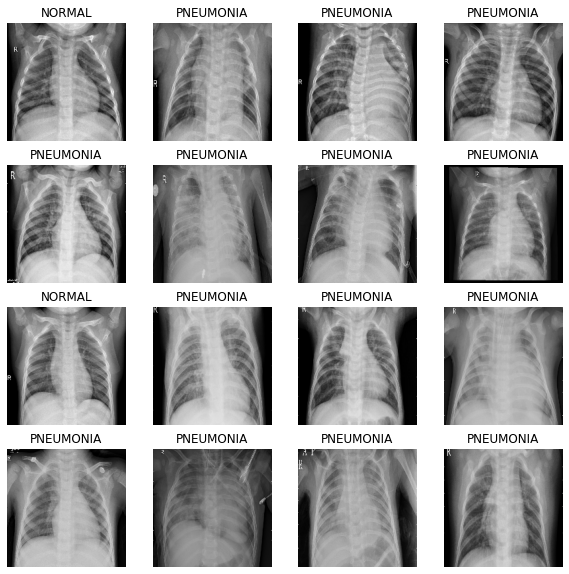

In [75]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### ※mini batch를 사용하는 이유  
  
<b>1.Batch Size</b>  
데이터를 학습하는 과정에서 최적화 Gradient descent 할 때 한번에 몇개의 데이터를 가지고 하는지 나타 
데이터가 엄청나게 많을 경우 전체 데이터를 보고 최적화를 할 때 엄청난 시간이 할애될 수 있으므로 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것  
  
<b>2.SGD(Stochastic Gradient Descent):확률적 경사 하강법</b>    
하나의 Training data ( Batch size = 1 ) 마다 Cost 를 계산하고 바로 Gradient descent를 적용하여 weight 를 빠르게 updatae  
한 개의 Training data 마다 매번 weight 를 갱신하기 때문에 신경망의 성능이 들쑥날쑥 변함( Cost 값이 안정적으로 줄어들지 않음 )  
최적의 Learning rate 를 구하기 위해 일일이 튜닝하고 수렴 조건 ( early - Stop ) 을 조정해야함  
SGD 는 batch size 가 1 을 뜻하는 최적화 방법으로 위의 그림처럼 시간을 기하급수적으로 단축 시킬 수 있다.  
시간만 봤을 때 효율 최고 !!  
하지만 정확도 측면을 고려하면 데이터확인을 적게하기 때문에 그만큼 정밀한 정확도를 얻기 힘들다.  
  
<b>3.mini-batch</b>  
batch size를 1또는 max 가 아닌 적당한 값을 정해서 최적화 하는 방법  
Mini-Batch Stochasic Gradient Descent  
Training data 에서 일정한 크기 ( == Batch size ) 의 데이터를 선택하여 Cost function 계산 및 Gradient descent 적용  
앞선 두 가지 Gradient descent 기법의 단점을 보완하고 장점을 취함  
설계자의 의도에 따라 속도와 안정성을 동시에 관리할 수 있으며, GPU 기반의 효율적인 병렬 연산이 가능해진다.  
SGD 는 변동성이 아주크고 정확하지 않지만 속도가 빠르다,  
그에 비에 Batch ( Full Batch : 기존의 사용한 GD ) 는 정확하게 수렴하지만 시간이 너무 오래걸린다.  
그 중간 Mini-Batch를 통해 어느정도 시간을 절약하면서 납득할 만한 결과를 얻을 수 있다.  
  
총 데이터 수가 10,000개, batch size가 1,000일 경우  
1 iteration = 1,000개 데이터에 대한 1회의 Gradient descent   
1 epoch = 10,000 / batch size = 10 iteration ( 10회의 경사하강법 실행 )  
https://acdongpgm.tistory.com/202  

## Model 설계  
  
<b>CNN 모델설계</b>  
  
step1. convolution block 만들기  
-convolution 2번 진행   
-batch normalization 통해 gradient vanishing, gradient exploding 해결  
-max pooling  
  
※tf.keras.layers.SeparableConv2D:depthwise convolution(2D convolution 가능)  
이를 사용하는 이유는 엄청난 컴퓨팅을 급격히 줄여 경감시키기 위함  
RGB  색상에 따른 channel 수가 3이므로 channel별로 5X5X1 kernel 을 준비하면 입력 이미지와 channel 두께가 3이므로 서로 일치한다.  
따라서 평면상에서 8X8 컨보루션 시키면 결과 8X8X3이 얻어진다.  
즉 5X5X3 kernel 을 8X8 만큼 컨볼루션 시키면 5X5X3 X 8X8 = 4,800 만큼의 곱셈이 수반된다.  
https://blog.daum.net/ejleep1/1204  
  
step2. dense block 만들기==> batch normalization과 dropout 함께 쓰는게 성능 향상에 도움이 되는지 여부 확인하기  
Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있음  
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 함  
이유는 batch normalization은 variance shift 억제하고 dropout은 이를 유발 시키기 때문  
그러나 예외적으로 두 방법을 같이 사용하는게 권장되기도 함  
  
step3. build model 함수  
convolution block과 dense block을 활용해 모델 설계  


In [42]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [54]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리  
normal과 pneumonia 중에 Pneumonia 데이터가 많아 imbalance data임  
<b>해결방법(Weight balancing)</b>  
training set의 각 데이터에서 loss 계산할 때 특정 클래스의 데이터에 더 큰 loss 값 갖도록 가중치 부여  
model.fit 호출시 파라미터로 넘기는 class_weight에 클래스 가중치를 세팅할 수 있도록 지원  
딥러닝에서 클래스 불균형 다루는 방법:https://3months.tistory.com/414  
  
weight_for_0:normal 이미지에 사용할 weight 세팅
weight_for_1:pneumonia 이미지에 사용할 weight 세팅  
위의 weight들은 normal, pneumonia 전체 데이터 건수에 반비례하도록 설정  

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 훈련  
1.GPU 선택  
2.build_model을 model에 선언  
3.이미지 라벨 2개 밖에 없어 binary_cross entropy loss를 사용  
4.optimizer로 adam 사용  
5.metrics(성과측정) 'accuracy', 'precision', 'recall'을 사용

In [46]:
#early stopping 적용
checkpoint = tf.keras.callbacks.ModelCheckpoint("pneumonia_classification",
                                                   save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=METRICS,
    )

In [72]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        #callbacks=[checkpoint, early_stopping]
    )

Epoch 1/25
261/261 [==============================] - 57s 188ms/step - loss: 0.0956 - accuracy: 0.9667 - precision: 0.9917 - recall: 0.9633 - val_loss: 0.1951 - val_accuracy: 0.9163 - val_precision: 0.9018 - val_recall: 0.9948
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.0716 - accuracy: 0.9753 - precision: 0.9944 - recall: 0.9723 - val_loss: 0.0644 - val_accuracy: 0.9798 - val_precision: 0.9831 - val_recall: 0.9895
Epoch 3/25
261/261 [==============================] - 48s 185ms/step - loss: 0.0382 - accuracy: 0.9871 - precision: 0.9971 - recall: 0.9855 - val_loss: 0.1418 - val_accuracy: 0.9471 - val_precision: 0.9958 - val_recall: 0.9320
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.0317 - accuracy: 0.9878 - precision: 0.9977 - recall: 0.9858 - val_loss: 0.0579 - val_accuracy: 0.9837 - val_precision: 0.9934 - val_recall: 0.9843
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.0169 - accura

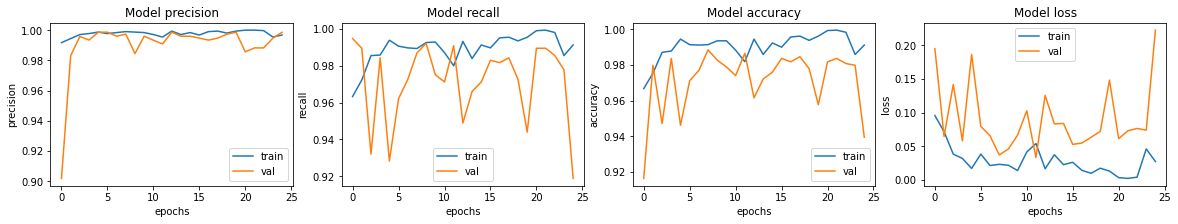

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [74]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.0479 - accuracy: 0.9006 - precision: 0.8832 - recall: 0.9692
Loss: 1.0478956699371338,
Accuracy: 0.9006410241127014,
Precision: 0.8831775784492493,
Recall: 0.9692307710647583


### Batchnormalization과 dropout 성능 비교  
제일 처음에 셋팅된 환경 batchsize=16, epochs=25, 모델 아키텍쳐 그대로 사용, early stopping도 적용하지 않고 수행한 실험  
batchnormalization과 drop을 함께 쓰는 것 보다 batchnomalization을 쓰는게 가장 성능이 좋았다.  

In [34]:
import pandas as pd
df = pd.DataFrame({'batchnormalization&dropout':[1.50, 0.74, 0.71, 1.0], 'batchnormalization':[0.88, 0.82, 0.81, 0.93], 'dropout':[1.30, 0.80, 0.76, 0.98]}, index=['Loss', 'Accuracy', 'Precision', 'Recall'])
df

,batchnormalization&dropout,batchnormalization,dropout
Loss,1.50,0.88,1.30
Accuracy,0.74,0.82,0.80
Precision,0.71,0.81,0.76
Recall,1.00,0.93,0.98


## Result
  
<b>최종 accuracy 0.9006410241127014</b>  
흠... 왜 기본 모델 아키텍쳐가 가장 성능이 좋게 나왔는지 이유를 모르겠고 솔직히 이게 좋은 결과인지도 모르겠다.  
실험 조건은 batch size:16, epochs:25, 기본 모델의 dense block에서 batchnormalization만 사용, earlystopping 적용x, optimizer:Adam,  learning_rate:0.001이다.   
learning rate는 cs231n ch6에서 learning rate를 가장 먼저 조정하라는 설명을 듣고 이 실험에 적용했다.  
아마 90% 성능이 나온건 다른 것 보다 learning rate를 조절했기 때문일 것이다.  
그러나 loss 그래프에서 마지막에 val_loss가 점프하는데 이게 과연 좋은 모델인지 의문이다.  
  
<b>batch size, epoch 조절</b>  
batch size는 16 -> 32 -> 128 -> 256으로 조절하고 epochs는 25 -> 50 -> 100으로 조절했다.  
배치사이즈나 에포크 수가 크다고 성능이 좋다고 할 수 없고 둘의 비율도 중요한 것 같다.  
augmentation을 적용안한 이 경우는 배치사이즈가 16, 에포크는 25일 때 가장 성능이 좋지만 아래의 augmentation을 적용하면 배치사이즈가 32이고 에포크가 50일 때 가장 성능이 좋기 때문에 상황에 맞는 설정이 중요하다.

## Data augmentation적용  
  
총 7개의 augmentation을 적용했다.  
1. random_flip_left_right  
2. random_flip_up_down  
3. random_brightness  
4. random_saturation  
5. random_crop  
6. random_central_crop  
7. rescale  
  
우선 augmentation을 적용했을 때 결과부터 언급하자면  
좌우반전했을 때 보다 <b>상하반전</b>이 더 성능이 잘 나와서 상하반전을 사용했다.  
그 후 <b>밝기와 채도</b>를 조절했으나 오히려 성능이 급격히 떨어져서 제외했다.  
원래는 이미지에 zoom을 적용하고 싶었는데 아래 함수에서 쓰인 tf.image에는 zoom 기능이 없어 <b>central_crop</b>으로 외곽의 불필요한 부분은 제거했다.  
그 결과 상하반전만 사용했을 때보다 정확도 차이가 0.15정도 있어 central crop역시 제외했다.  

In [133]:
#training, validation data augmentation 
def augment(image,label):
    #image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_flip_up_down(image) #위아래 반전 
    #image = tf.image.random_brightness(image, 0.2)
    #image = tf.image.random_saturation(image, lower=0.2, upper=0.5)
    #image = tf.image.random_crop(value=image, size=(0.1, 0.1, 3))
    #mage = tf.image.central_crop(image, central_fraction=0.8)
    image = image/255.0 #정규화 
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def prepare_for_test(ds): #test data augmentation 적용
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    
    return ds

#학습 데이터와 테스트 데이터 생성 
aug_train_ds = prepare_for_training(train_ds)
aug_val_ds = prepare_for_training(val_ds)
aug_test_ds = prepare_for_test(test_ds)

## 데이터 시각화

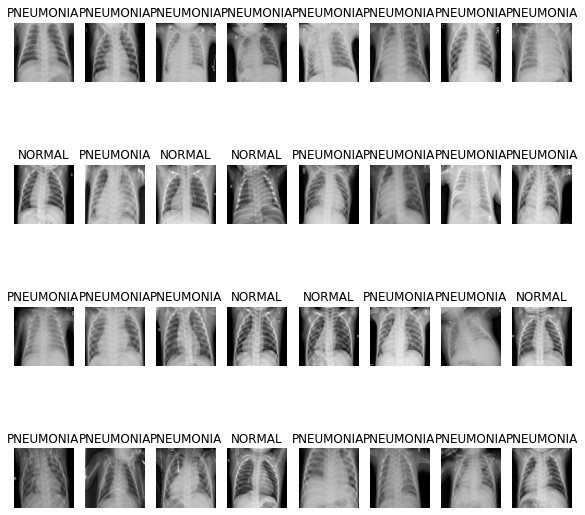

In [124]:
#정규화하기 이전의 시각화 
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


aug_image_batch, aug_label_batch = next(iter(aug_train_ds))
show_batch(aug_image_batch.numpy(), aug_label_batch.numpy())

## 모델 설계 & hyperparameter tuning  
  
<b>시도했으나 좋은 결과를 얻지 못한 방법</b>  
  
1. 마지막 Dense layer에 softmax 적용  
softmax를 적용해 보았는데 accuracy가 0.7점대에 머물렀다.  
  
  
2. layer수 추가  
층수가 깊어질수록 학습하는 정보가 많으니까 Conv layer를 한층 더 추가했으나 accuracy 0.65로 더 안 좋아졌다.  
그래서 conv_block dropout을 추가하고 dense_block에 노드 수를 높였으나 이것 역시 accuracy 0.65로 결과가 좋지 못했다.   

처음에 85%이상의 성능에 집착해 이것저것 시도 했는데 대부분 accuracy가 0.79에 머물러 있었다.  
그래서 방향을 바꿔 training data의 overfitting을 최대한 줄여 그래프가 요동치지 않고 부드럽게 수렴할 수 있도록 했다.  
  
<b>overfitting을 줄이기 위한 시도</b>  
  
1. 첫번째 layer에 Batchnormalization을 추가  
정규화 효과를 얻고 overfitting을 막고자 batchnormalization을 추가했으나 이 역시 accuracy 0.7에 머물었다.  
  
  
2. dropout 조정  
overfitting을 막고자 dropout 수치를 0.2에서 0.5로 높였으나 성능이 오히려 accuracy 0.69로 떨어졌다.  

In [135]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), #0.2
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2), #0.2
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2), #0.2
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        #tf.keras.layers.Flatten(),
        #dense_block(512, 0.7),
        #dense_block(128, 0.5),
        #dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Model compile  
  
<b>early stopping추가</b>  
모델을 돌리다보니 시간이 너무 오래걸리고 그래프 상에 val_loss가 너무 요동치길래 적용했다.  
patience는 10을 설정했다.  
사실 early stopping을 배제하고 끝까지 학습시켰을 때 성능이 더 좋은데 그 이유는 모르겠다.  
  
<b>optimizer 조정</b>  
Adam, RMSprop, SGD momentum 설정했는데 기본 Adam이 성능이 가장 좋았다.  
더 성능을 올리기 위해 Adam의 learning rate를 0.1 -> 0.01 -> 0.001 -> 0.0001로 큰 수치에서 낮은 수치로 옮겨가며 실험을 진행했고  
0.001일 때 accuracy가 가장 높았다.  

In [134]:
#early stopping 적용
checkpoint = tf.keras.callbacks.ModelCheckpoint("pneumonia_classification",
                                                   save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

with tf.device('/GPU:0'): #GPU 설정 
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        #optimizer = 'adam',
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), #learning rate 조절 0.001
        #optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD'),
        #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=METRICS
    )

## 모델 학습 

In [136]:
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        #callbacks=[checkpoint, early_stopping]
    )

Epoch 1/50
130/130 [==============================] - 56s 366ms/step - loss: 0.7535 - accuracy: 0.5510 - precision: 0.7921 - recall: 0.5370 - val_loss: 0.6938 - val_accuracy: 0.2607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
130/130 [==============================] - 48s 370ms/step - loss: 0.3113 - accuracy: 0.8601 - precision: 0.9624 - recall: 0.8449 - val_loss: 0.5775 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/50
130/130 [==============================] - 48s 373ms/step - loss: 0.2174 - accuracy: 0.9125 - precision: 0.9747 - recall: 0.9061 - val_loss: 0.5872 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/50
130/130 [==============================] - 49s 377ms/step - loss: 0.1892 - accuracy: 0.9236 - precision: 0.9790 - recall: 0.9170 - val_loss: 0.5932 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/50
130/130 [==============================] - 50s 386ms/step - loss: 0.1586 

## 학습 결과 시각화 

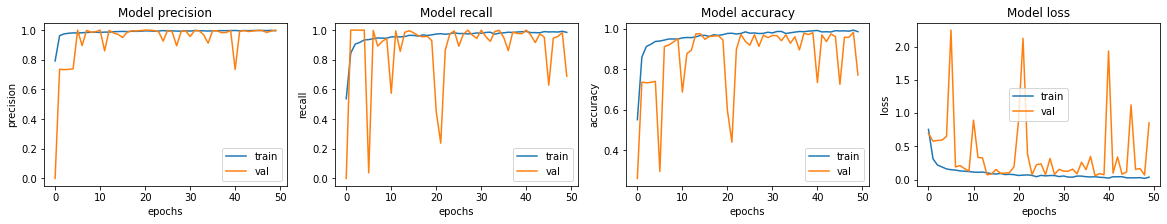

In [137]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 최종 성능 확인  
  
<b>data augmentation</b>  
best accuracy의 조건은 32 배치사이즈, 50에포크 , dense_block에서 batchnormalization만 사용, optimizer는 Adam, learning rate는 0.001, earlystopping 적용x => 최종 <b>0.85accuracy</b>  
이번 모델은 earlystopping을 적용하지 않을 때가 적용할 때 보다 더 학습 효과가 좋았다. 
earlystopping을 적용하면 25에포크에서 멈추고 결과는 0.74accuracy이다.  

In [138]:
loss, accuracy, precision, recall = model.evaluate(aug_test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 220ms/step - loss: 0.5670 - accuracy: 0.8510 - precision: 0.9231 - recall: 0.8308
Loss: 0.5670344233512878,
Accuracy: 0.8509615659713745,
Precision: 0.9230769276618958,
Recall: 0.8307692408561707


## augmentation 결과 비교  
  
이미지를 정규화하지 않고 기본 모델(dense_block에서 batchnormalization과 dropout 모두 사용)에서 augmentation을 5개 경우로 나눠 학습한 결과를 표로 나타냈다.  
정규화를 하지 않은 이유는 정규화의 영향 없이 다른 augmentation만 적용했을 때 성능이 어떻게 나오는지 비교해 보기 위함이다.  
이 이후의 실험에서는 이미지를 모두 정규화 처리했다.  
해당 실험 결과 상하반전(flip_up_down)만 적용했을 때 가장 성능이 좋았다.  
그러나 나중에 언급하겠지만 이후의 실험에서는 좌우반전의 성능이 상하반전의 성능을 모두 뛰어넘는다.  

In [93]:
import pandas as pd
df2 = pd.DataFrame({'flip_left_right':[4.02, 0.76, 0.75, 0.99],'flip_up_down':[0.88, 0.80, 0.76, 0.98],'flip_up_down&central_crop':[1.32,0.73,0.70,0.99],'flip_up_down&brightness':[0.68, 0.62, 0.62, 1.0], 'flip_up_down&saturation':[0.68,0.37,0.0,0.0]}, index=['Loss', 'Accuracy', 'Precision', 'Recall'])
df2

,flip_left_right,flip_up_down,flip_up_down&central_crop,flip_up_down&brightness,flip_up_down&saturation
Loss,4.02,0.88,1.32,0.68,0.68
Accuracy,0.76,0.80,0.73,0.62,0.37
Precision,0.75,0.76,0.70,0.62,0.00
Recall,0.99,0.98,0.99,1.00,0.00


## Discussion  
1. 좌우 반전을 한 상태에서 dense_block 함수에서 batchnormalization만 적용했을 때 0.76 accuracy로 dropout만 적용한 결과인 0.67 보다 높았다. 이는 batchnormalization의 regularization 효과와 또, overfitting을 효과적으로 막아주기 때문일 것이다. dropout이나 batchnomalization냐 아님 둘다 적용할 것이냐는 상황에 맞게 판단해야 하는 것 같다.  
  
  
2. 모든 모델의 결과를 시각화했을 공통점이 있는데 loss 그래프에서 train 데이터는 항상 loss가 처음부터 낮게 시작해서 거의 0에 가까운 반면 validation은 처음에 매우 높았다가 갑자기 뚝 떨어진다는 점이다. 이는 데이터 수가 적어 파라미터를 너무 빠르게 학습하고 overfitting이 일어났기 때문이지 않을까싶다.  
  
  
3. 모든 모델의 또 다른 공통점은 recall 값이 너무 크다는데 있다. 처음부터 recall이 1로 시작하고 최소 epoch 10이상은 되어야 recall 값이 떨어진다. 이 뜻은 웬만한 이미지는 폐렴으로 분류한다는 것인데 이러면 정확한 분류를 원하는 의료 영상 분석의 목적에 맞지 않다. precision을 높이고 recall 값을 더 낮춰 적정한 trade-off관계를 보이는 모델이 필요하다.  
  
  
4. Kaggle에서 다른 사람들의 kernel을 보니 Imagedatagen을 많이 활용해서 augmentation을 진행했다. imagedatagen을 활용하고 싶었으나 최대한 주어진 조건하에서 루브릭 기준 85%를 달성하고 싶어 기존 모델을 여러 방법으로 변형했었다.  
  
  
5. 결론은 augmentation하지 않았을 때가 augmentation을 했을 때보다 0.13 accuracy가 더 높았다.  
